In [1]:
import time
import pandas as pd
import os
import torch
from torchvision.transforms import v2 as transforms
from torchvision.models.resnet import resnet18
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import PurePosixPath, PureWindowsPath
from tempfile import TemporaryDirectory

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = int(self.annotations.iloc[idx, 1])
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


class UnlabeledImageDataset(Dataset):
    def __init__(self, img_dir, return_label=0.5, transform=None):
        self.images = [file.name for file in os.scandir(img_dir)]
        self.img_dir = str(img_dir)
        self.transform = transform
        self.return_label = return_label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        image = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.return_label

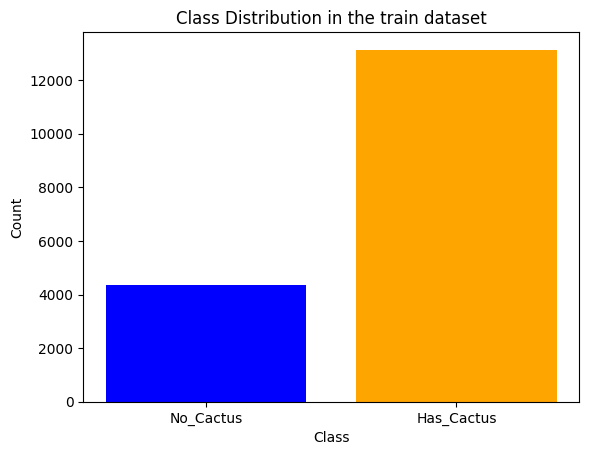

In [3]:


count_0 = 4364  # -> 12000/13000
count_1 = 13136

plt.bar(['No_Cactus', 'Has_Cactus'], [count_0, count_1], color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in the train dataset')
plt.show()

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

csv_file = PurePosixPath("data/train.csv")
if os.name == 'nt':
    csv_file = PureWindowsPath(csv_file)

train_dir = PurePosixPath("data/train/train")
if os.name == 'nt':
    train_dir = PureWindowsPath(train_dir)

augmented_folder = PurePosixPath("data/train/train_augmented")
if os.name == 'nt':
    augmented_folder = PureWindowsPath(augmented_folder)

test_dir = PurePosixPath("data/test/test")
if os.name == 'nt':
    test_dir = PureWindowsPath(test_dir)

In [5]:
# Da eseguire solo una volta per generare le immagini augmentate


# train_dataset = CustomImageDataset(
#     csv_file=csv_file,
#     img_dir=train_dir,
#     transform=transform
# )

# dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# print(len(dataloader))

# # Augmentations to apply
# augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(np.random.uniform(0, 45)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
# ])

# output_dir = "data\\train\\train_augmented"
# os.makedirs(output_dir, exist_ok=True)

# # How many new versions of each image to generate?
# num_augmented = 2

# i = 0
# for images, labels in tqdm(dataloader):
#     for (image, label) in zip(images, labels):
#         if label == 0:
#             for j in range(num_augmented):
#                 aug_img = augment(image)
#                 new_filename = f"aug_{i}_{j}.jpg"
#                 aug_img.save(os.path.join(output_dir, new_filename))
#         i+=1

Train set size: 20983
Test set size: 5245


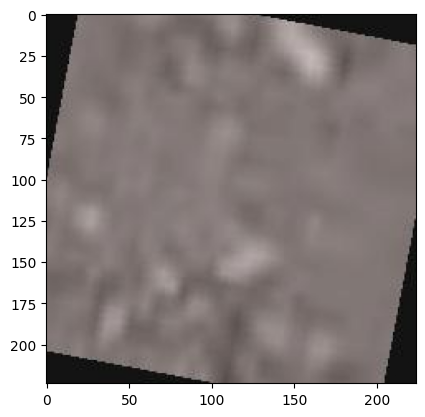

In [6]:
train_dataset = CustomImageDataset(
    csv_file=csv_file,
    img_dir=train_dir,
    transform=transform
)

augmented_dataset = UnlabeledImageDataset(
    img_dir=augmented_folder,
    return_label=0,
    transform=transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
)

training_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset])

generator = torch.Generator().manual_seed(42)
train_set, validaton_set = torch.utils.data.random_split(training_dataset, [0.8, 0.2], generator=generator)
print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(validaton_set)}")


training_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validaton_set, batch_size=32, shuffle=True)


for (i, (images, labels)) in enumerate(training_dataloader):
    for (img, label) in zip(images, labels):
        if label == 0:
            plt.imshow(img.permute(1, 2, 0))
            break
    break

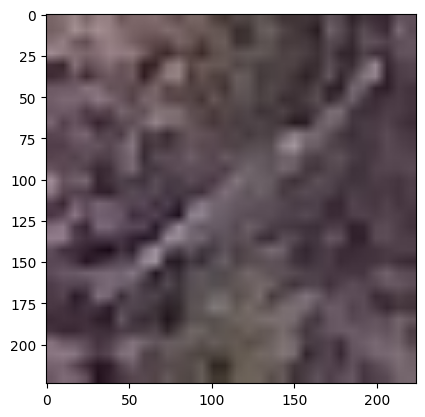

In [7]:
test_dataset = UnlabeledImageDataset(
    img_dir=test_dir,
    transform=transform
)

test_dataloader = DataLoader(test_dataset, shuffle=False)


for (i, (images, labels)) in enumerate(test_dataloader):
    for (img, label) in zip(images, labels):
        plt.imshow(img.permute(1, 2, 0))
        break
    break

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_f1 = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0
            tp = 0
            fp = 0
            fn = 0

            # Iterate over data.
            for inputs, labels in training_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                tp += (labels * preds).sum().to(torch.float32)
                fp += ((1 - labels) * preds).sum().to(torch.float32)
                fn += (labels * (1 - preds)).sum().to(torch.float32)

            scheduler.step()

            epoch_loss = running_loss / len(training_dataloader.dataset)
            epoch_acc = running_corrects.double() / len(training_dataloader.dataset)

            # Calculate F1 score
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

            print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {f1:.4f}')

            model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            tp = 0
            fp = 0
            fn = 0

            # Iterate over data.
            for inputs, labels in validation_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                tp += (labels * preds).sum().to(torch.float32)
                fp += ((1 - labels) * preds).sum().to(torch.float32)
                fn += (labels * (1 - preds)).sum().to(torch.float32)

            epoch_loss = running_loss / len(validation_dataloader.dataset)
            epoch_acc = running_corrects.double() / len(validation_dataloader.dataset)

            # Calculate F1 score
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

            print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {f1:.4f}')

            # deep copy the model
            if f1 > best_f1:
                best_f1 = f1
                torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val f1: {best_f1:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [10]:
model_conv = resnet18(weights="DEFAULT")

# Freeze all layers
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
# model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
# torch.save(model_conv.state_dict(), "model.pt")
model_conv.load_state_dict(torch.load("model.pt", map_location=device))

<All keys matched successfully>

In [12]:
def test(model, dataloader):
    model.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, true_labels in tqdm(dataloader):
            inputs = inputs.to(device)
            true_labels = true_labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == true_labels.data)
    accuracy = corrects.double() / len(dataloader.dataset)
    print(f'Accuracy: {accuracy:.4f}')

In [13]:
# model_conv.eval()  # Set model to evaluate mode

# with torch.no_grad():
#     for inputs, _ in tqdm(test_dataloader):
#         inputs = inputs.to(device)

#         outputs = model_conv(inputs)
#         _, preds = torch.max(outputs, 1)

#         print(f"Predicted: {preds}, True: {labels}")
#         print()

cleaned_csv = PurePosixPath('data/pseudo_labeled_cleaned.csv')
if os.name == 'nt':
    cleaned_csv = PureWindowsPath(cleaned_csv)

cleaned_testset = CustomImageDataset(
    csv_file=cleaned_csv,
    img_dir=test_dir,
    transform=transform
)

test_dataloader = DataLoader(cleaned_testset, batch_size=64, shuffle=True)

test(model_conv, test_dataloader)

100%|██████████| 63/63 [00:03<00:00, 17.78it/s]

Accuracy: 0.1862
